In [1]:
import json
import re

d = open('./tweets-zeitgemaessebildung.json').readlines()
dl = [json.loads(di) for di in d]

# Get only the text from tweets without RT (not a retweet)

In [2]:
dlt = [di['extended_tweet']['full_text'] if 'extended_tweet' in di else di['text'] for di in dl if 'RT ' not in di['text']]

# Remove URLs

In [6]:
dlt_clean = [re.sub(r'^.*https?:\/\/.*[\r\n]*', '', di, flags=re.MULTILINE) for di in dlt]

# Remove empty tweets

In [7]:
dlt_clean = list(filter(lambda t: t != '', dlt_clean))

In [8]:
len(dlt_clean)

56

In [9]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from spacy.lang.de import stop_words

# Creating a vectorizer
vectorizer = TfidfVectorizer(min_df=0, max_df=0.9, stop_words=stop_words.STOP_WORDS, lowercase=True, token_pattern=r'\b[^\d\W][^\d\W]+\b')
data_vectorized = vectorizer.fit_transform(dlt_clean)


In [10]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print(' '.join([vectorizer.get_feature_names()[i]
                        for i in topic.argsort()[:-top_n - 1:-1]]))
        print ('\n')

In [11]:
NUM_TOPICS = 6
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


/home/aivuk/.virtualenvs/twitter/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


# Show important words for topics using LDA method

In [12]:
selected_topics(lda, vectorizer)

Topic 0:
twlz zeitgemäßebildung wegweiser bildung kostenfrei herunterladen digitale samr digitalebildung unterricht


Topic 1:
fernunterricht apps relaunch glückwunsch twlz digitalität digitallearning danke wunderbare verändert


Topic 2:
selbstwirksamkeit schule themenseiten tolles dutzend ninabremm diskutieren bildungsmaterialspenden team gelernt


Topic 3:
exakt zeitgemäßebildung lernen kreativität bastian rat freihalten projektmanagement vergessen vertrauen


Topic 4:
bildung nachhaltige sichtbar kompetenzentwicklung amp margarethe_xyz gymnasiallehrer idee mint diplom


Topic 5:
engagierte verschiedenen mitwirkende suchen vorhandenen fachredaktionen aktuell ausschreibung zeitgemäßebildung angebote




# Show important words for topics using NMF method

In [13]:
selected_topics(nmf, vectorizer)

Topic 0:
mitwirkende vorhandenen engagierte verschiedenen ausschreibung fachredaktionen suchen aktuell bitte angebote


Topic 1:
bildung fernunterricht zeitgemäße amp mitmachen twlz mololdigital weiterbildung holen onlinetagungen


Topic 2:
wirlernenonline bildungsplattform arbeitet gefällt bereich physiker mint diplom gymnasiallehrer olaf


Topic 3:
digitalität samr schule blaupause kultur genau mischung weg zentraler eingeschränkter


Topic 4:
twlz zeitgemäßebildung digitalebildung apps unterricht überblick exakt twitterlehrerzimmer findet arbeiten


Topic 5:
innen digitalen dikola_mlu online seminar jugendhaus düsseldorf bigdata selbstverteidigung bildungsreferent




# Show important words for topics using LSI method

In [14]:
selected_topics(lsi, vectorizer)

Topic 0:
verschiedenen vorhandenen mitwirkende engagierte fachredaktionen ausschreibung suchen aktuell bitte angebote


Topic 1:
twlz zeitgemäßebildung bildung fernunterricht zeitgemäße schule amp apps wegweiser samr


Topic 2:
wirlernenonline bildungsplattform arbeitet gefällt bereich physiker gymnasiallehrer mint diplom olaf


Topic 3:
digitalität samr schule genau blaupause kultur realität zentraler referentialität eingeschränkter


Topic 4:
bildung mitmachen zeitgemäße amp gerechte bündnis willkommen herzlich setzen freie


Topic 5:
digitalebildung thema freuen zeitgemaessebildung bilsal mal schulschließungen unserem drauf verändert




In [15]:
# Function to group tweets by topic
def get_topics(method, data, tweets):
    topics = []
    methodt = method.transform(data)
    for n in range(methodt.shape[0]):
        topics += [methodt[n].argmax()]
        
    tweet_topics = {}
    for i,t in enumerate(tweets):
        if topics[i] not in tweet_topics:
            tweet_topics[topics[i]] = []
        tweet_topics[topics[i]] += [t]
    return tweet_topics

In [16]:
# Group tweets for each topic
lda_topics = get_topics(lda, data_vectorized, dlt_clean)
nmf_topics = get_topics(nmf, data_vectorized, dlt_clean)
lsi_topics = get_topics(lsi, data_vectorized, dlt_clean)

In [17]:
# Number tweets per topic
print("LDA Topics\n")
for t in lda_topics.keys():
    print("Topic {}: {}".format(t, len(lda_topics[t])))


LDA Topics

Topic 5: 16
Topic 0: 10
Topic 1: 8
Topic 2: 6
Topic 3: 9
Topic 4: 7


In [18]:
# Number tweets per topic
print("NMF Topics\n")
for t in nmf_topics.keys():
    print("Topic {}: {}".format(t, len(nmf_topics[t])))


NMF Topics

Topic 0: 7
Topic 5: 7
Topic 2: 5
Topic 4: 21
Topic 1: 9
Topic 3: 7


In [19]:
# Number tweets per topic
print("LSI Topics\n")
for t in lsi_topics.keys():
    print("Topic {}: {}".format(t, len(lsi_topics[t])))


LSI Topics

Topic 0: 6
Topic 5: 9
Topic 1: 23
Topic 3: 9
Topic 2: 4
Topic 4: 5


In [20]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

In [21]:
def create_wordcloud(text, filename): 
    stopwords = set(stop_words.STOP_WORDS)
    # create wordcloud object
    wc = WordCloud(background_color="black",
                    max_words=200, 
                    width=600,
                    height=600,
                    stopwords=stopwords)
    wc.generate(text)
    # save wordcloud
    wc.to_file(filename)

In [22]:
create_wordcloud(' '.join(dlt_clean), 'all_tweets.png')

In [23]:
from IPython.display import Image

# Tag cloud for all tweets

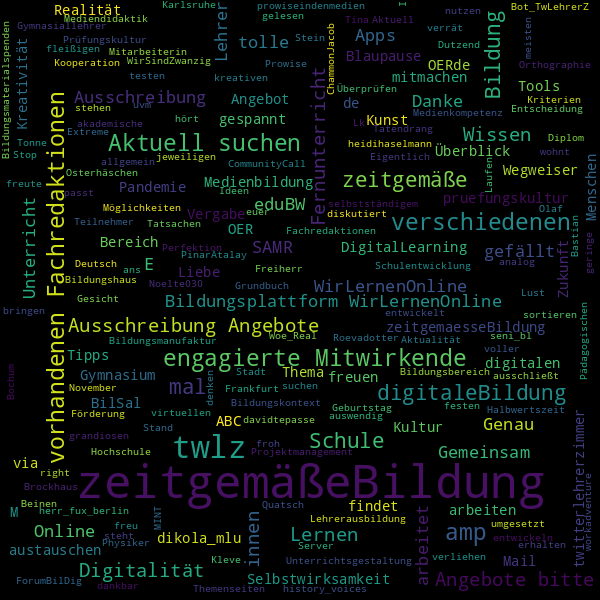

In [24]:
Image('all_tweets.png')

In [25]:
for t in lda_topics.keys():
    tweet_text = ' '.join(lda_topics[t])
    create_wordcloud(tweet_text, 'lda-topic-{}.png'.format(t))
    Image('lda-topic-{}.png'.format(t))

# Tag clouds for topics with LDA method

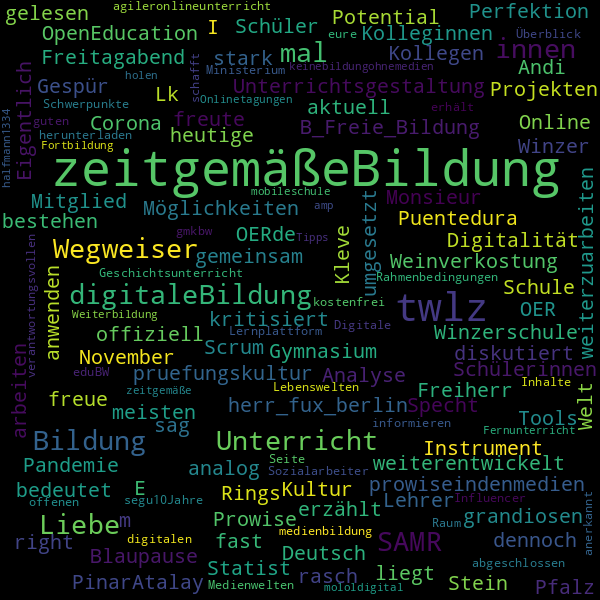

In [26]:
Image('lda-topic-0.png')

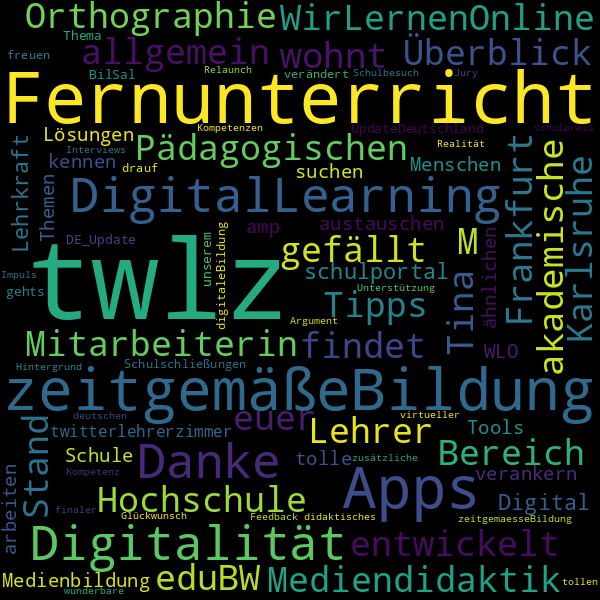

In [27]:
Image('lda-topic-1.png')

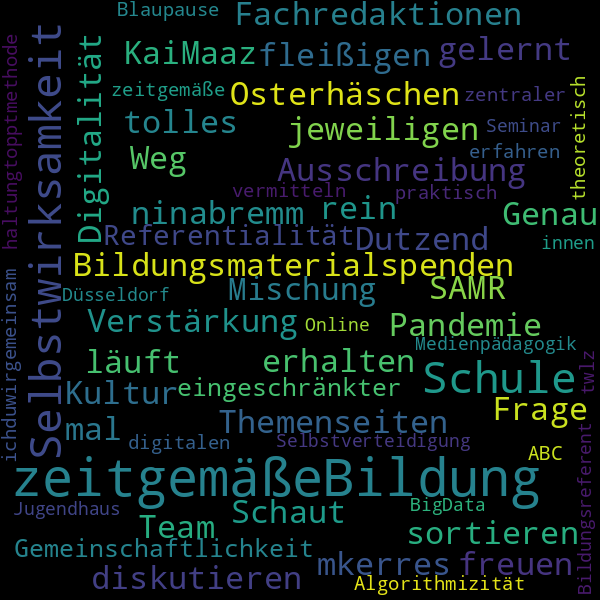

In [28]:
Image('lda-topic-2.png')

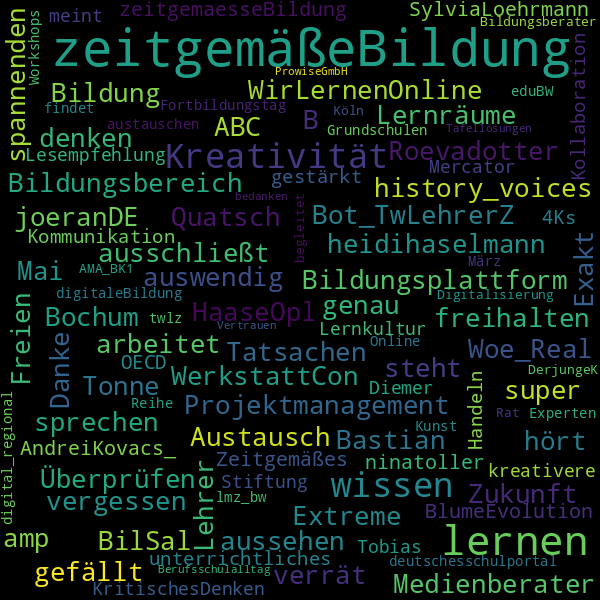

In [29]:
Image('lda-topic-3.png')

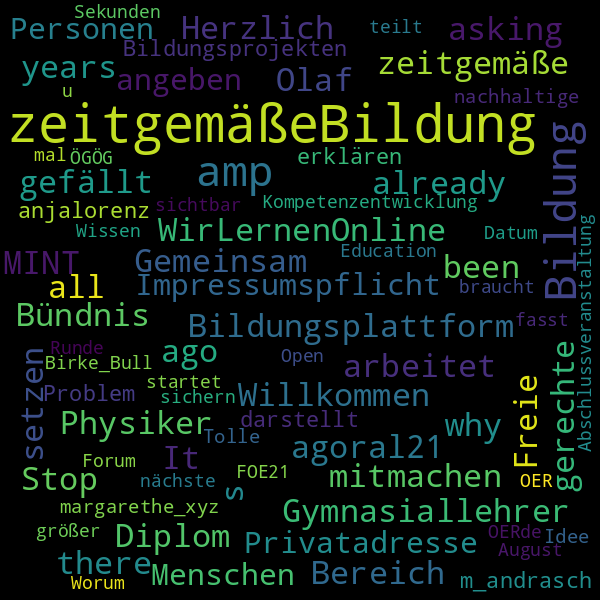

In [30]:
Image('lda-topic-4.png')

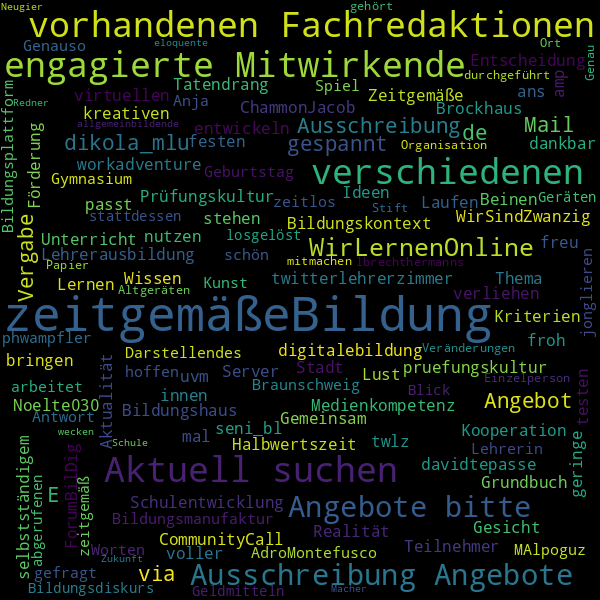

In [31]:
Image('lda-topic-5.png')

# Tag cloud for topics for LSI method

In [32]:
for t in lsi_topics.keys():
    tweet_text = ' '.join(lda_topics[t])
    create_wordcloud(tweet_text, 'lsi-topic-{}.png'.format(t))
    Image('lsi-topic-{}.png'.format(t))

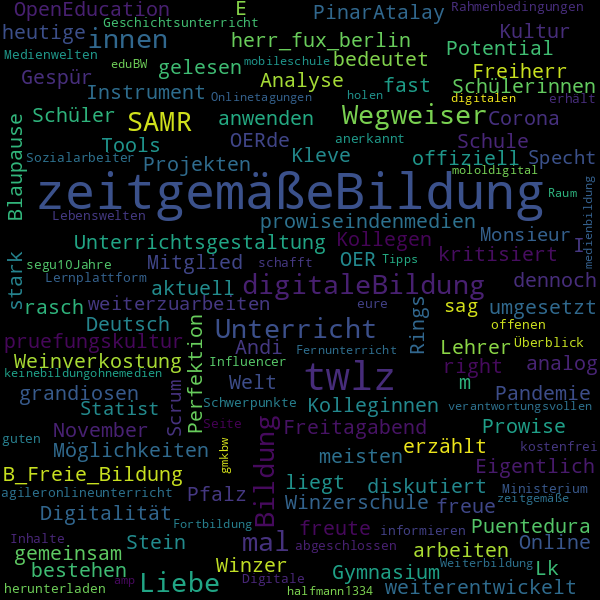

In [33]:
Image('lsi-topic-0.png')

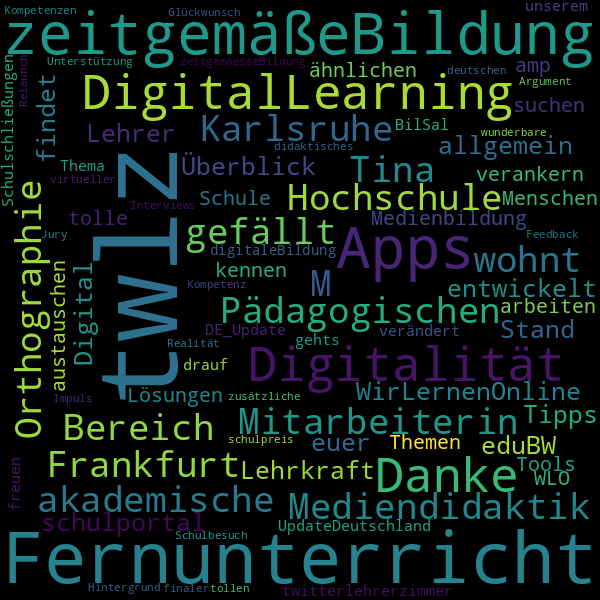

In [34]:
Image('lsi-topic-1.png')

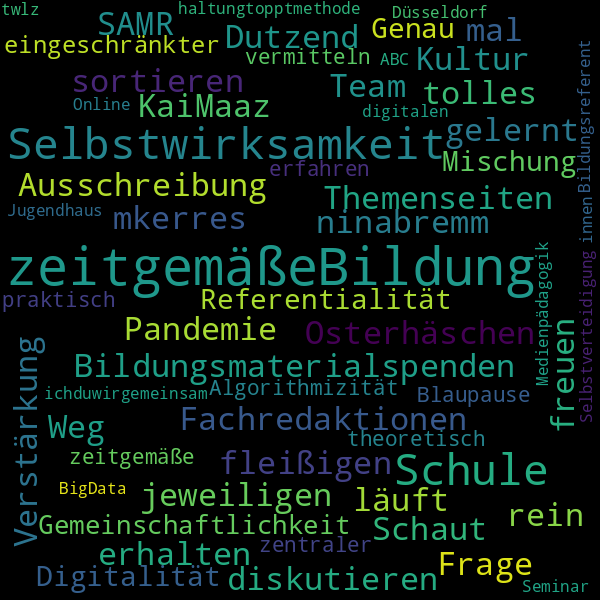

In [35]:
Image('lsi-topic-2.png')

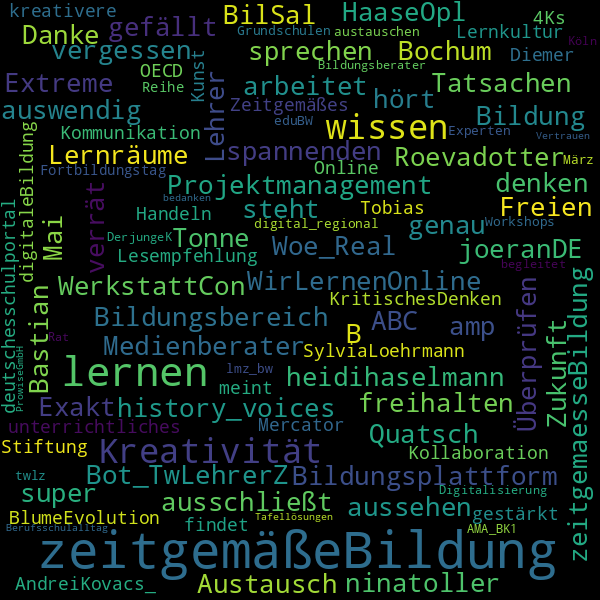

In [36]:
Image('lsi-topic-3.png')

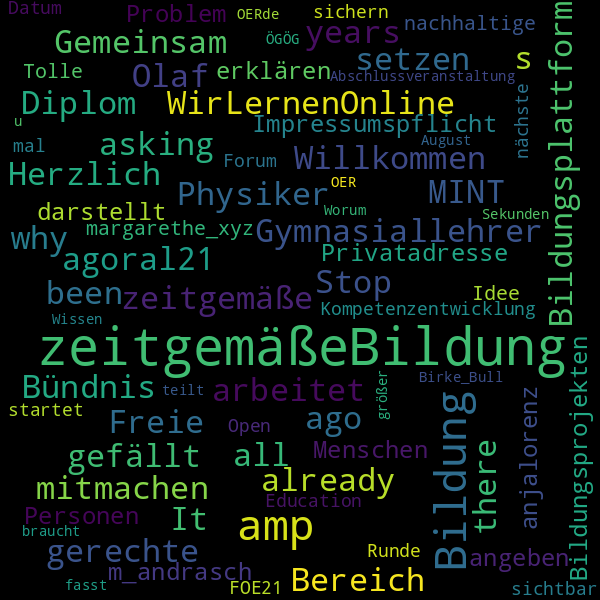

In [37]:
Image('lsi-topic-4.png')

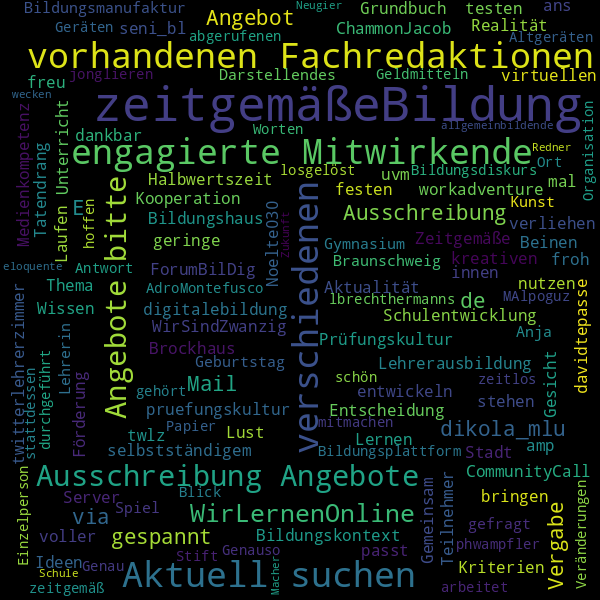

In [38]:
Image('lsi-topic-5.png')

In [39]:
for t in lsi_topics.keys():
    tweet_text = ' '.join(lda_topics[t])
    create_wordcloud(tweet_text, 'nmf-topic-{}.png'.format(t))


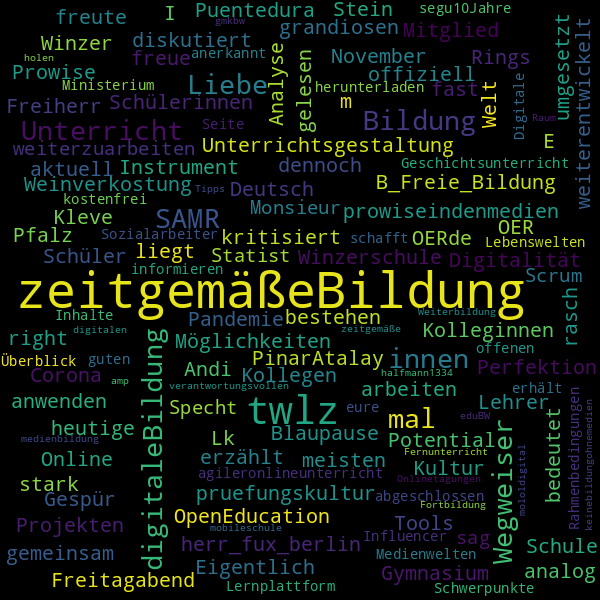

In [40]:
    Image('nmf-topic-0.png'.format(t))

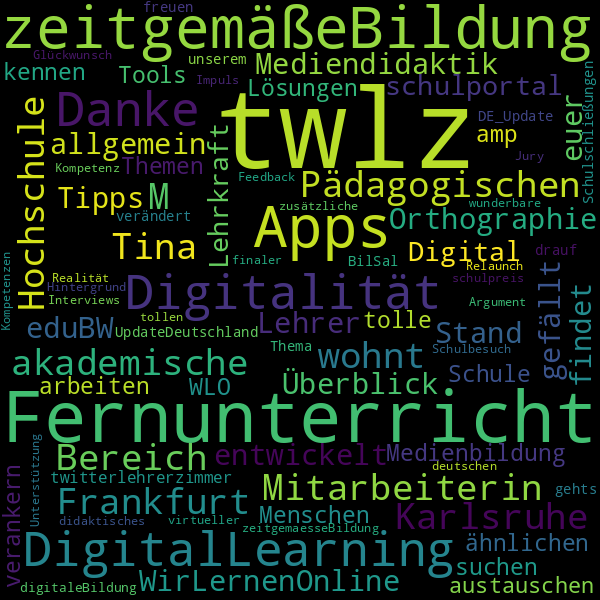

In [41]:
    Image('nmf-topic-1.png'.format(t))

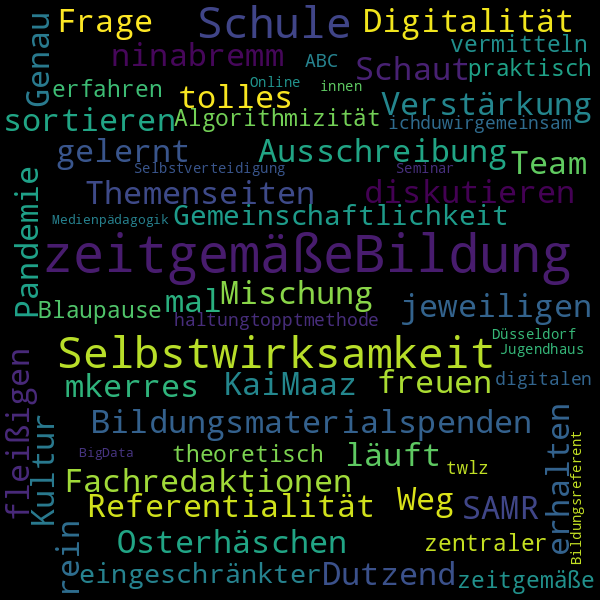

In [42]:
    Image('nmf-topic-2.png'.format(t))

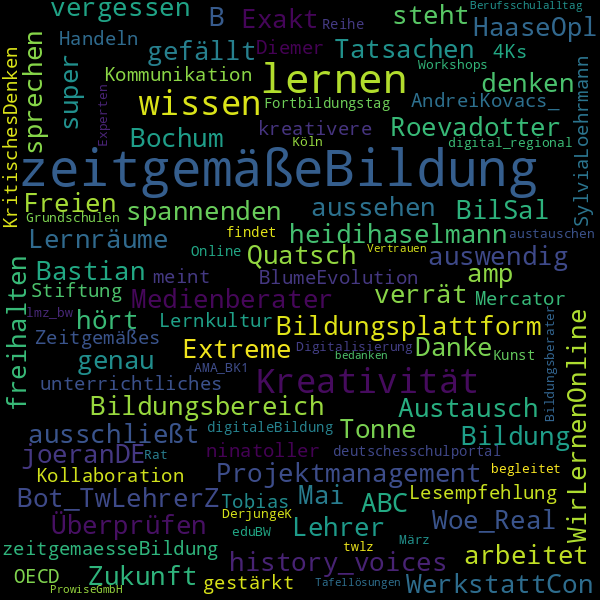

In [43]:
    Image('nmf-topic-3.png'.format(t))

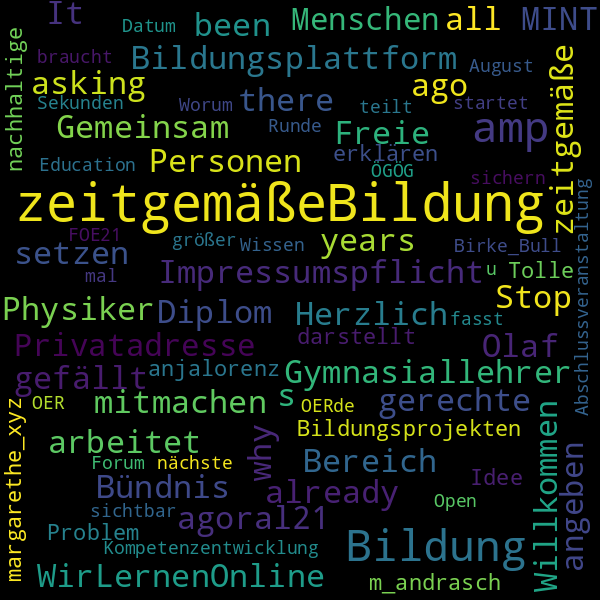

In [44]:
    Image('nmf-topic-4.png'.format(t))

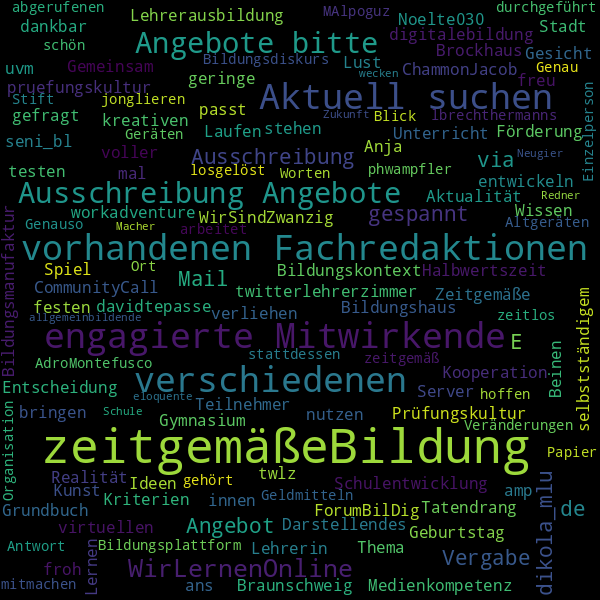

In [45]:
    Image('nmf-topic-5.png'.format(t))

In [46]:
for t in lsi_topics[5][:100]:
    print(t, '\n')

bin schon mal gespannt auf die #CommunityCall von @ForumBilDig !

Thema "Zeitgemäße Prüfungskultur" mit @pruefungskultur @Noelte030 @ChammonJacob @davidtepasse uvm. 
Wer ist noch dabei?
 

Wer hat Lust mit mir #workadventure auf einem eigenen virtuellen Server ans Laufen zu bringen um es im Bildungskontext (Unterricht, Lehrerausbildung, Schulentwicklung) zu testen und zu nutzen? 
#twitterlehrerzimmer
#twlz #zeitgemäßebildung #digitalebildung 

Unsere Ausschreibung für die Fachredaktionen läuft noch. Schaut mal rein, ob das was für euch ist. 

Wir sind ein tolles Team und freuen uns über Verstärkung! 

 

Danke an alle für diesen super spannenden Austausch! 💚 Und nicht vergessen: den 6. Mai für die WerkstattCon freihalten! 🗓️ #BilSal #zeitgemaesseBildung @ninatoller 

Gleich gehts los mit unserem #BilSal rund um das Thema "Ein Jahr nach den ersten Schulschließungen – was hat sich verändert?". Wir freuen uns drauf! #digitaleBildung #zeitgemaesseBildung #twlz 

Glückwunsch zum Relaunch! 🥳